# Molecular Dynamics Simulation of Alanine Dipeptide

In this notebook, we will be using the latest AMBER force fields. The OpenMM documentation contains [a complete overview of included force fields](http://docs.openmm.org/latest/userguide/application.html#force-fields). The corresponding data files can be viewed on the [GitHub repository](https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data). These files are already included in every OpenMM installation, so you don't need to download them.

Just to avoid getting lost in the force field zoo, here are the key references to various AMBER force fields and some comments on the history of their development:

- 1997 `amber96.xml`: a slight improvement of AMBER ff94 with ab initio calculations, not very significant. [REF](https://doi.org/10.1007/978-94-017-1120-3_2)

- 2006 `amber99sb.xml`: a refinement of amber ff94 side-chain and mostly backbone (SB) torsional parameters, to obtain better balance between stabilities of different secondary structure elements, in the literature referred to as AMBER ff99SB. [REF](https://dx.doi.org/10.1002%2Fprot.21123)

- 2003 `amber03.xml`: improvement of AMBER ff99SB by refitting of torsional parameters to ab initio data, referred to as AMBER ff03. [REF](https://doi.org/10.1002/jcc.10349)

- 2010 `amber99sbildn.xml`: refitting of AMBER ff99sb to improve side-chain conformations to match NMR data, in the literature referred to as AMBER ff99SB-ILDN. [REF](https://dx.doi.org/10.1002%2Fprot.22711)

- 2010 `amber99sbnmr.xml`: another (not as popular) refitting of AMBER ff99SB parameters to NMR data. [REF](https://doi.org/10.1002/anie.201001898)

- ???? `amber10.xml`: origin not clear (yet), it is certainly an intermediate step in the development of AMBER ff14SB.

- 2015 `amber14-all.xml` or `amber14/protein.xml`: improved side-chain and backbone parameters starting from AMBER ff99SB, in the literature referred to as AMBER ff14SB. [REF](https://doi.org/10.1021/acs.jctc.5b00255)

One of the more recent and widely used AMBER force field is **AMBER ff14SB**. If for some reason, you need to use an older model, **AMBER ff99SB-ILDN** or **AMBER ff99SB** could be useful. The remaining ones are rarely used anymore. Also a few newer developments exist but will not be used in this course.

Another popular family of biomolecular force fields are the CHARMM force fields. The [CHARMM36](https://doi.org/10.1021/ct300400x) force field was published in 2012 and its development followed similar steps as that of AMBER. In 1992 the CHARMM22 force field was released. In 2004, so-called [CMAP corrections](https://doi.org/10.1021/ja036959e) were released based on *ab initio* reference data, to improve the accuracy of the backbone conformations. In CHARMM36 this was taken one (big) step further, with more accurate *ab initio* data and follow-up refinements against NMR data.
The files `charmm36.xml` and `charmm36/*.xml` were only included recently in OpenMM and these will not be used for this year's edition of the tutorial.


## 1. Gas phase (AMBER)

All imports and initialization are put in the first cell.

In [ ]:
from sys import stdout

import matplotlib.pyplot as plt
import mdtraj
import nglview
import numpy as np
import pandas
from openmm import *
from openmm.app import *
from openmm.unit import *

We will run test simulations on tiny "protein": alanine dipeptide. Data files for this notebook were taken from the [OpenMM test systems](https://github.com/openmm/openmm/tree/master/wrappers/python/tests/systems). The files `alanine-dipeptide-implicit.*` were renamed as follows:

* `alanine-dipeptide.pdb` (All-atom PDB file.)
* `alanine-dipeptide.inpcrd` (AMBER input coordinates)
* `alanine-dipeptide.prmtop` (AMBER parameters and topology)

The simulation code below closely follows the water example from the previous notebook with a few minor differences:

- The topology and the initial positions are now taken from a PDB file

- A Langevin integrator is used, with different settings and more MD steps.

- The AMBER 2014 force field is used.

- X-H bonds are constrained in length, where X can be any atom. This allows us to take time steps of 2 femtoseconds.

This is an unrealistic simulation because the dipeptide is simulated in gas phase (no solvation).

In [9]:
pdb = PDBFile("alanine-dipeptide.pdb")
print(pdb.topology)

forcefield = ForceField("amber14-all.xml")

system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3 * nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300 * kelvin, 1 / picosecond, 2 * femtoseconds)

simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

<Topology; 1 chains, 3 residues, 22 atoms, 21 bonds>



**<span style="color:#A03;font-size:14pt">
&#x270B; HANDS-ON! &#x1F528;
</span>**

> Modify the PDB file to understand which pieces of information are essential to apply the force-field definition. Try making changes to:
>
> 1. the atom names, 
> 2. the name of a residue, 
> 3. the order of the atoms (within one residue or mixing residues) and 
> 4. the presence of atoms.
>
> Also note that the PDB file contains no bonds. These are somehow reconstructed when loading the PDB file. Try displacing one atom over a large distance. Does this affect the bond detection?

In the next cell, an MD simulation is carried out and the trajectory is written to a DCD file. This is a compact binary file format for trajectory data. This does not only save disk space. Also loading DCD files is much faster compared to PDB trajectory files.

In [10]:
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj1.dcd", 100))
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars1.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
simulation.step(100000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Elapsed Time (s)"
1000,242.8802493405399,0.0
2000,209.71619645822128,0.32135796546936035
3000,297.88060828209433,0.639507532119751
4000,389.8957955091083,0.9596502780914307
5000,281.8380617576163,1.2917633056640625
6000,283.743532027631,1.6578137874603271
7000,232.05331706791145,2.0228357315063477
8000,325.60412567328797,2.4047868251800537
9000,315.327126820262,2.7239327430725098
10000,396.0105729425262,3.057041883468628
11000,178.67962033911144,3.377246141433716
12000,265.82597612891396,3.706498861312866
13000,239.73462658196178,4.065910577774048
14000,288.492121192858,4.402011394500732
15000,267.9030205880119,4.728139638900757
16000,244.9004922355716,5.049279451370239
17000,297.9747437851652,5.365463733673096
18000,286.83148959367435,5.7046215534210205
19000,185.1763374627411,6.027757167816162
20000,344.71532406908557,6.332970142364502
21000,346.01497696067935,6.659098148345947
22000,285.9428158995468,7.037982702255249
23000,438.4604310876237,7.419995069503

In the next code cell, the potential energy as function of time is plotted. It reveals a very short equilibration phase. Because the energy was first minimized, the potential energy starts low and increases quickly due to the motion of the atoms.

Normally, the equilibration phase should be discarded prior to further analysis. For now, the equilibration phase is included in the analysis to explain and show this aspect.

<Axes: xlabel='#"Time (ps)"'>

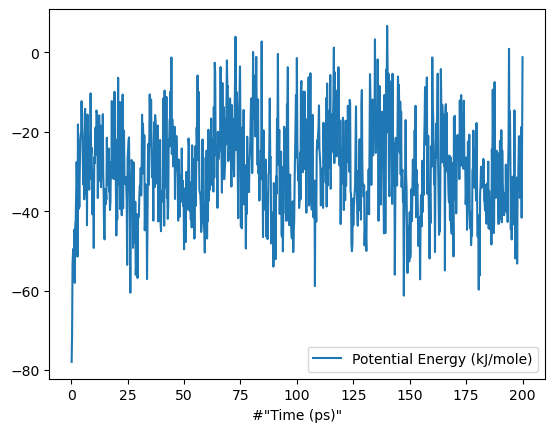

In [11]:
df1 = pandas.read_csv("scalars1.csv")
plt.close("ener1")
fig, ax = plt.subplots(num="ener1")
df1.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)

The visualization below shows a few changes in conformation of the dipeptide.

In [12]:
traj1 = mdtraj.load("traj1.dcd", top="alanine-dipeptide.pdb")
traj1.superpose(traj1, 0)
nglview.show_mdtraj(traj1)

NGLWidget(max_frame=999)

The following cell defines a function to draw a [Ramachandran plot](https://en.wikipedia.org/wiki/Ramachandran_plot) with MatPlotLib. As opposed to a conventional Ramachandran plot, data points represents different conformations (time steps) of the $\phi$ and $\psi$ angles.

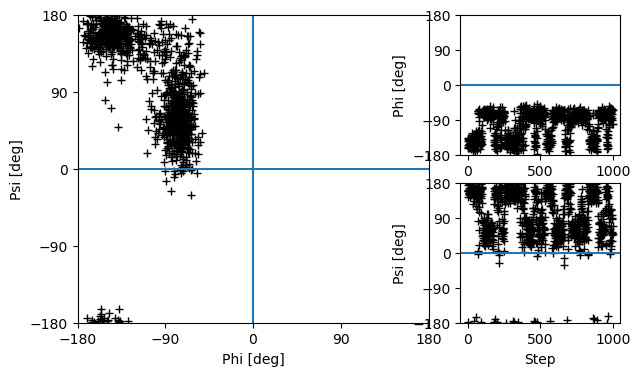

In [13]:
def plot_ramachandran(traj, num, phi_atoms=None, psi_atoms=None):
    """Generate a basic Ramachandrom plot for a given trajectory.

    Parameters
    ----------
    traj
        An MDTraj trajectory object.
    phi_atoms
        A list of atom names (in order) to identify the phi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.
    psi_atoms
        A list of atom names (in order) to identify the psi angle.
        The defaults in MDTraj do not work for termini in CHARMM
        topologies, which can be fixed with this argument.

    """

    if phi_atoms is None:
        phis = mdtraj.compute_phi(traj)[1].ravel()
    else:
        phis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, phi_atoms)[1]
        )
    if psi_atoms is None:
        psis = mdtraj.compute_psi(traj)[1].ravel()
    else:
        psis = mdtraj.compute_dihedrals(
            traj, mdtraj.geometry.dihedral._atom_sequence(traj.topology, psi_atoms)[1]
        )
    plt.close(num)
    fig = plt.figure(num=num, figsize=(7, 4))
    gs = fig.add_gridspec(2, 3)
    # Ramachandran plot
    ax1 = fig.add_subplot(gs[:2, :2])
    ax1.plot(phis * 180 / np.pi, psis * 180 / np.pi, "k+")
    ax1.axvline(0)
    ax1.axhline(0)
    ax1.set_xlim(-180, 180)
    ax1.set_ylim(-180, 180)
    ax1.set_xticks(np.linspace(-180, 180, 5))
    ax1.set_yticks(np.linspace(-180, 180, 5))
    ax1.set_xlabel("Phi [deg]")
    ax1.set_ylabel("Psi [deg]")
    # ax1.set_aspect("equal", adjustable="datalim")
    # Phi(t) plot
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(np.arange(len(phis)), phis * 180 / np.pi, "k+")
    ax2.axhline(0)
    ax2.set_ylim(-180, 180)
    ax2.set_yticks(np.linspace(-180, 180, 5))
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Phi [deg]")
    # Psi(t) plot
    ax3 = fig.add_subplot(gs[1, 2])
    ax3.plot(np.arange(len(phis)), psis * 180 / np.pi, "k+")
    ax3.axhline(0)
    ax3.set_ylim(-180, 180)
    ax3.set_yticks(np.linspace(-180, 180, 5))
    ax3.set_xlabel("Step")
    ax3.set_ylabel("Psi [deg]")


# Function call to make the plot
plot_ramachandran(traj1, "ram1")

## 2. Implicit solvent model (AMBER with GBSA-OBC)

OpenMM supports various parameterizations of the generalized-Born Surface Area (GBSA) model, e.g. that by 
Onufriev, Bashford and Case (OBC), see https://doi.org/10.1002/prot.20033. For a limited number of force fields, atomic GBSA-OBC parameters were generated according to a recipe in the [TINKER](https://dasher.wustl.edu/tinker/) program:

- `amber96_obc.xml` for `amber96.xml`
- `amber03_obc.xml` for `amber03.xml`
- `amber10_obc.xml` for `amber10.xml`
- `amber99_obc.xml` for `amber99sb.xml`, `amber99sbildn.xml` or `amber99sbnmr.xml`

These can be used by changing the force field definition, e.g. to `ForceField('amber99sbildn.xml', 'amber99_obc.xml')`. Keep in mind that these extra atomic parameters for GBSA-OBC deviate from those in the [AMBER](http://ambermd.org/) program. OpenMM does not natively support implicit solvent models for AMBER ff14SB, and workarounds for this problem are not covered in this course. Instead, a slightly older AMBER parametrization will be used instead.

In [18]:
forcefield = ForceField("amber99sbnmr.xml", "amber99_obc.xml")
system = forcefield.createSystem(pdb.topology, nonbondedCutoff=3 * nanometer, constraints=HBonds)
integrator = LangevinIntegrator(300 * kelvin, 1 / picosecond, 2 * femtoseconds)
simulation = Simulation(pdb.topology, system, integrator)
simulation.context.setPositions(pdb.positions)
simulation.minimizeEnergy()

simulation.reporters = []
simulation.reporters.append(DCDReporter("traj2.dcd", 100))
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars2.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
simulation.step(100000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

#"Step","Temperature (K)","Elapsed Time (s)"
1000,283.8073145884846,0.0
2000,252.59256112095912,0.31316161155700684
3000,258.81584987299715,0.6099157333374023
4000,265.9513821794498,0.8964827060699463
5000,340.51265604953426,1.200697898864746
6000,276.28791742002574,1.5041027069091797
7000,264.8255884939289,1.7903294563293457
8000,281.01624730076156,2.1144635677337646
9000,354.88037508187705,2.3937156200408936
10000,318.25000540299584,2.7039551734924316
11000,273.4058272901706,2.992194652557373
12000,291.3171398747505,3.2746803760528564
13000,372.758671869795,3.5793159008026123
14000,313.3866256204921,3.869807481765747
15000,300.7827417893235,4.1504857540130615
16000,322.53892831584255,4.419675588607788
17000,320.4593469481183,4.7414984703063965
18000,312.18002869638343,5.079561233520508
19000,268.11829797605526,5.412668704986572
20000,278.58732821751295,5.747789144515991
21000,224.70304714120832,6.0838892459869385
22000,313.03073872241464,6.411019802093506
23000,253.65219726733795,6.7

With the implicit solvent model, the computational cost increases by approximately 60%.
This increase may vary with system size.

The potential energy as a function of time shows a short equilibration phase, comparable to the previous example:

<Axes: xlabel='#"Time (ps)"'>

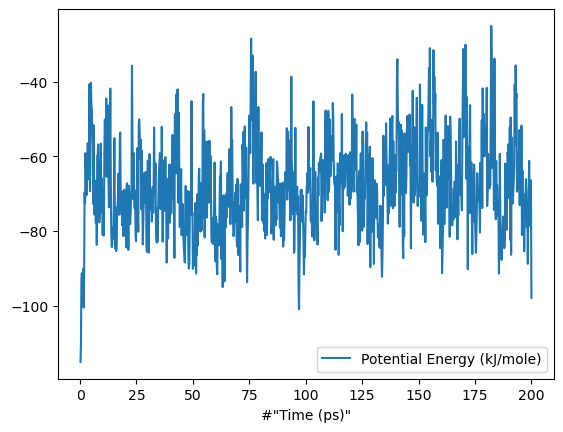

In [19]:
df2 = pandas.read_csv("scalars2.csv")
plt.close("ener2")
fig, ax = plt.subplots(num="ener2")
df2.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)

We can now compare the structure of the backbone with and without implicit solvent. Also compare with figures obtained by other students.

In [ ]:
traj2 = mdtraj.load("traj2.dcd", top="alanine-dipeptide.prmtop")
plot_ramachandran(traj2, "ram2")

## 3. Explicit solvent model (AMBER)

Any implicit solvent model will always be a serious approximation of explicit water molecules surrounding a solute. Before we can run such a simulation, we need to construct a topology and initial geometry of alanine dipeptide with a large number of water molecules. This can be done in several ways and for simplicity, we will use the built-in tools from OpenMM. For this example, we can again start from a PDB file.

This example is based on the following parts of the OpenMM documentation:

* http://docs.openmm.org/latest/userguide/application.html#model-building-and-editing
* http://docs.openmm.org/latest/api-python/generated/openmm.app.modeller.Modeller.html#openmm.app.modeller.Modeller


One is in principle free to combine any biomolecule with any water force field, but not all combinations may have been carefully tested. Always check the original papers in which the force field was published to select matching pairs. To avoid confusion, the latest AMBER and CHARMM force fields in OpenMM are bundeled with matching water force fields. Here are a few sensible combinations:

* `amber14-all.xml` can be paired with any TIP or SPC model in the `amber14` directory, see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data/amber14

* `charm36.xml` should be combined with water force fields in the `charmm36` directory, see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data/charmm36. Note that `charmm36/water.xml` is a slightly modified form of TIP3P.

* The parameters in `amber99sbildn.xml` [were tested](https://dx.doi.org/10.1002%2Fprot.22711) with TIP3P (`tip3p.xml`) and TIP4P-Ew (`tip4pew.xml`), see https://github.com/openmm/openmm/tree/master/wrappers/python/openmm/app/data.

The files from the Github repository should normally never be downloaded and links are only provided for reference. These files are included with any OpenMM installation and are already present on your machine.

In [16]:
pdb = PDBFile("alanine-dipeptide.pdb")
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addSolvent(forcefield, model="tip3p", padding=1.2 * nanometer)
print(modeller.topology)
# Write a PDB file to provide a topology of the solvated
# system to MDTraj below.
with open("init3.pdb", "w") as outfile:
    PDBFile.writeFile(modeller.topology, modeller.positions, outfile)

# The modeller builds a periodic box with the solute and solvent molecules.
# PME is the method to compute long-range electristatic interactions in
# periodic systems.
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, constraints=HBonds)
temperature = 300 * kelvin
pressure = 1 * bar
integrator = LangevinIntegrator(temperature, 1 / picosecond, 2 * femtoseconds)
system.addForce(MonteCarloBarostat(pressure, temperature))
simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy()
simulation.reporters.append(DCDReporter("traj3.dcd", 100))
simulation.reporters.append(
    StateDataReporter(stdout, 1000, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars3.csv",
        100,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
simulation.step(100000)

# The last line is only needed for Windows users,
# to close the DCD file before it can be opened by nglview.
del simulation

<Topology; 2 chains, 426 residues, 1291 atoms, 867 bonds>
#"Step","Temperature (K)","Elapsed Time (s)"
1000,255.45996268684252,0.0
2000,295.6570864178535,0.6332576274871826
3000,298.0760427094416,1.2819247245788574
4000,295.39988191498577,1.9314019680023193
5000,290.13865595033707,2.5716848373413086
6000,305.16428487335673,3.231771945953369
7000,302.32650646862373,3.928879976272583
8000,307.92632416219976,4.616136312484741
9000,295.7014547049696,5.281098127365112
10000,299.1496373051493,5.953198432922363
11000,303.54436604697884,6.6408851146698
12000,304.3889513243205,7.343596935272217
13000,303.2637298260176,8.008094787597656
14000,311.43343764680054,8.6944739818573
15000,297.55305946417144,9.396381378173828
16000,293.0189199387962,10.07334041595459
17000,296.25231557031424,10.754369735717773
18000,315.743580835125,11.418666362762451
19000,298.0365739877739,12.098637580871582
20000,290.8117110706379,12.760171890258789
21000,311.2045871106481,13.446950197219849
22000,307.2375949690987,

This computation was considerably slower, approximately a factor of 10 more expensive.

Before going further, we plot the potential energy as function of time, to estimate the length of the equilibration phase. There was barely any equilibration in the previous two runs, mainly because the few degrees of freedom were all relatively fast motions. More complex structures tend to exhibit also slower motions. For example, in our current run with explicit water molecules, the solvent needs more time to equilibrate.

<Axes: xlabel='#"Time (ps)"'>

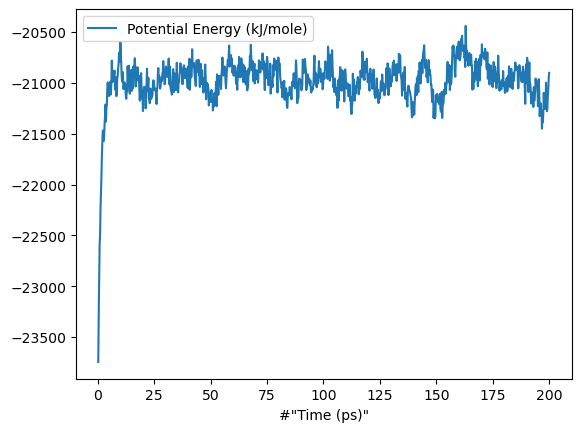

In [20]:
df3 = pandas.read_csv("scalars3.csv")
plt.close("ener3")
fig, ax = plt.subplots(num="ener3")
df3.plot(kind="line", x='#"Time (ps)"', y="Potential Energy (kJ/mole)", ax=ax)

The figure above shows that approximately (the first) 15 picoseconds are required for the equilibration. Results for these steps need to be removed before performing any analysis. A single MD step takes 2 femtoseconds and only every 100 steps, a frame is written to the PDB file, which means that the first 75 frames from the trajectory should be removed. For the visualization, we still look at all steps.

In [21]:
traj3 = mdtraj.load("traj3.dcd", top="init3.pdb")
view = nglview.show_mdtraj(traj3)
view.clear_representations()
view.add_licorice()
view.add_unitcell()
view

NGLWidget(max_frame=999)

A few remarks on the visualization:

- The absolute position of the dipeptide relative to the box is not crucial. Due to the periodic boundary conditions, all molecules interact with an infinitely large environment, of which the visualization only shows a small fragment.

- The dipeptide slowly diffuses through the liquid, which is the expected behavior. Water molecules make larger jumps because they are smaller and lighter.

In the next cell, the equilibration phase is discarded and the water molecules are removed, before making the Ramachandran plot.

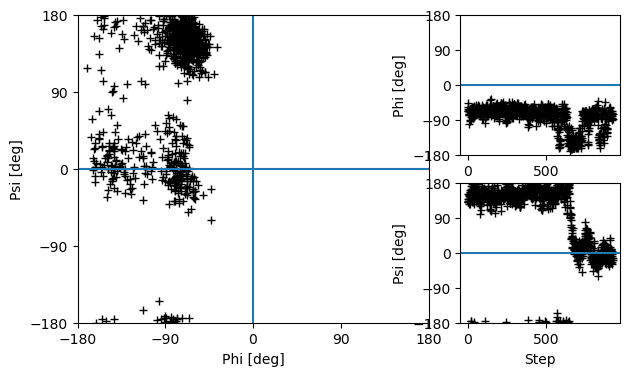

In [22]:
traj3.restrict_atoms(traj3.topology.select("protein"))
plot_ramachandran(traj3[75:], "ram3")

The Ramachandran plot is strongly influenced by the choice of solvent model. Already for a simple dipeptide, the limitations of an implicit solvent model are clear. The reason is that the amide groups participate in the hydrogen-bonding network of the solvent. These are rather specific and directional interactions, which are absent in implicit solvent models.

Another difference with the first two runs is the slower change of the back-bone angles. There are fewer changes between conformations and switching also takes longer. This is due to the friction with and the inertia of the surrounding water molecules. Hence, a single time step with explicit solvent is more costly and one has to perform longer simulations because water slows down conformational changes. For this reason, implicit solvent models are still popular, despite the fact that they are very approximate. Note that the explicit-solvent simulations in this notebook are not long enough to obtain converged statistics.